In [1]:
projectdir = "C:/Users/arman/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(projectdir)

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, Pipe, ProgressMeter, StatsPlots, Distributed, Roots, LinearAlgebra, BSON, Random
pyplot()

try 
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try SeqDataFormatting
catch e
    include(projectdir*"experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include(projectdir*"distribution_functions.jl")
include(projectdir*"simulated_tumors/path_format.jl")
include(projectdir*"Turnover/src/utility.jl")
include(projectdir*"sampling_analysis/plot_funcs.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Load data

In [2]:
tumorinfo = dir_info_mutations(projectdir*"/simulated_tumors/3d/bulk")
filter!(r->r.N==40_000 && r.ρ == Inf && r.d in 0.0:0.2:0.8 && r.μ == 0.3 && r.dim==3, tumorinfo)
for x in groupby(tumorinfo, :d)
    print("d=",first(x.d), ": ", nrow(x), ", ")
end

d=0.0: 20, d=0.2: 20, d=0.4: 20, d=0.6: 20, d=0.8: 20, 

In [3]:
tumorinfo.tumor = @showprogress pmap(TumorGrowth.data_import, tumorinfo.tumorpath)
tumorinfo.mutations = @showprogress pmap(TumorGrowth.data_import, tumorinfo.mutationspath)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:21:22
Progress: 100%|█████████████████████████████████████████| Time: 0:04:58


In [17]:
# bson(projectdir*"/simulated_tumors/3d/bulk/"*"siminfo_N40000_rhoInf_d0.6.bson", 
#     Dict(names(tumorinfo) .=> eachcol(tumorinfo)))

In [19]:
# tumorinfo = @time DataFrame( BSON.load(projectdir*"/simulated_tumors/3d/bulk/"*"siminfo_N40000_rhoInf_d0.6.bson") )

146.123518 seconds (192.01 M allocations: 11.157 GiB, 47.09% gc time)


Dict{String, Vector{T} where T} with 11 entries:
  "μ"             => [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.…
  "tumor"         => Any[40000×7 DataFrame…
  "b"             => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.…
  "mutations"     => Any[29568×5 DataFrame…
  "N"             => [40000, 40000, 40000, 40000, 40000, 40000, 40000, 40000, 4…
  "d"             => [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.…
  "mutationspath" => Any["C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/D…
  "tumorpath"     => Any["C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/D…
  "ρ"             => [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, In…
  "dim"           => [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, …
  "seed"          => [1333, 1561, 1613, 2730, 3402, 3676, 4135, 4191, 4454, 467…

In [16]:
mu = unique(tumorinfo.μ)[1]

0.3

# Sampling in plane

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


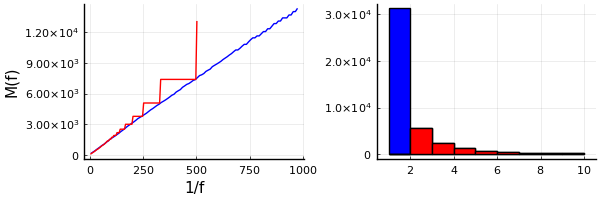

In [24]:
f_whole = Float64[]
f_sample = Float64[]
counts_all = Int[]
counts_pass = Int[]
@showprogress for row in eachrow(tumorinfo)
    t = row.tumor
    append!(f_whole, TumorGrowth.mutation_freqs(t).frequency)
    tumorsample = t[sample(1:nrow(t), 1000, replace=false), :]
    seq = TumorGrowth.mutation_freqs(tumorsample)
    append!(f_sample, seq.frequency)
    append!(counts_all, seq.reads)
    append!(counts_pass, seq.reads[seq.frequency .> 1/1000])
end
let res = 1/1000
    p = plot(layout=(1,2), size=(600,200), legend=:none)
    M!(p[1], f_whole, res=res, c=:blue)
    M!(p[1], f_sample, c=:red, res=res)
    histogram!(p[2], counts_all, bins=1:10, c=:blue)
    histogram!(p[2], counts_pass, bins=1:10, c=:red)
end

In [99]:
f_min, samplecutoff= 1/100, 1/5
samplingparams = (n = 280, cells_per_sample = 5)

tumor = rand( tumorinfo.tumor );
plane = TumorGrowth.cross_section(tumor; x=mean(tumor.position)[1], width=3, reduce_dim=true )
_, tumorsample = TumorGrowth.multi_region_sequencing(plane; samplingparams...);

┌ Warning: This method assumes mutations to be ordered by occurence!
└ @ TumorGrowth C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\TumorGrowth\src\analysis.jl:115


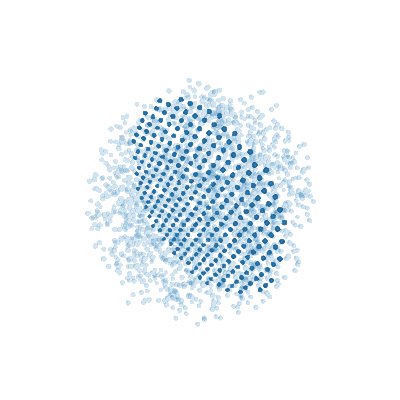

In [102]:
let t = deepcopy( tumorsample )
    x = mean(tumor.position)[1]
    for p in t.position
       pushfirst!( p, x)
    end
    sc = TumorGrowth.plotting_colored_mutations(t; size=(400,400), shading=true)
    TumorGrowth.plotting_colored_mutations!(sc, tumor[sample(1:nrow(tumor), 2000, replace=false),:]; 
            alpha=0.2, show_warning=false)
end

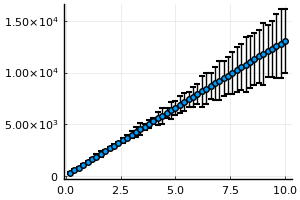

In [54]:
widths = 0.2:0.2:10.
planesizes = @showprogress map(widths) do width
    map( eachrow(tumorinfo) ) do row
        t = row.tumor
        seq_whole = TumorGrowth.mutation_freqs(t)
        append!(f_whole, seq_whole.frequency)
        plane = TumorGrowth.cross_section(tumor; x=mean(t.position)[1], width=width, reduce_dim=true )
        nrow(plane)
    end
end
scatter(widths, median.(planesizes), yerror=var.(planesizes), size=(300,200), lab="")

# Get turnover

In [4]:
samplecutoff= 1/3
samplingparams = (n = 285, cells_per_sample = 5)

(n = 285, cells_per_sample = 5)

In [ ]:
let random.seed!(1110)
    tumorinfo.samples = similar(tumorinfo.tumor)
    tumorinfo.Nthresh = similar(tumorinfo.d)
    @showprogress for row in eachrow( tumorinfo )
        
        tumor_3d, mutations = deepcopy( row.tumor ), row.mutations
        x, cm = mean(tumor_3d.position)
        tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=2., reduce_dim=true)
        
        _, tumorsample = TumorGrowth.multi_region_sequencing(tumor; 
            n = 30, cells_per_sample = samplingparams.cells_per_sample,
            stochastic = false, readdepth = 40)
        for row in eachrow(tumorsample)
            row.mutations = row.mutations[row.frequencies .> samplecutoff]
            row.frequencies = row.frequencies[row.frequencies .> samplecutoff]
        end
        
        
        
        _, tumorsample = TumorGrowth.multi_region_sequencing(tumor; 
            n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
            stochastic = false, readdepth = 40)
        
        
        
        for row in eachrow(tumorsample)
            row.mutations = row.mutations[row.frequencies .> samplecutoff]
            row.frequencies = row.frequencies[row.frequencies .> samplecutoff]
        end
        row.samples = tumorsample
        
        row.Nthresh = estim_N(tumorsample)

        tumor_freqs = TumorGrowth.mutation_freqs(tumor)
        samples_freqs = TumorGrowth.sampletumor_mfreqs(tumorsample)
        
        mutations.tumor_freq = zeros(nrow(mutations))
        mutations.tumor_freq[tumor_freqs.mutation] = tumor_freqs.frequency
        mutations.samples_freq = zeros(nrow(mutations))
        mutations.samples_freq[samples_freqs.mutation] = samples_freqs.frequency

    end
end

In [5]:
Random.seed!(1110)
let
    tumorinfo.samples = similar(tumorinfo.tumor)
    tumorinfo.Nthresh = similar(tumorinfo.d)
    @showprogress for row in eachrow( tumorinfo )
        
        tumor_3d, mutations = deepcopy( row.tumor ), row.mutations
        x, cm = mean(tumor_3d.position)
        tumor = TumorGrowth.cross_section(tumor_3d; x=x, width=3, reduce_dim=true)
        
        _, tumorsample = TumorGrowth.multi_region_sequencing(tumor; 
            n = samplingparams.n, cells_per_sample = samplingparams.cells_per_sample,
            stochastic = false, readdepth = 40)
        for row in eachrow(tumorsample)
            row.mutations = row.mutations[row.frequencies .> samplecutoff]
            row.frequencies = row.frequencies[row.frequencies .> samplecutoff]
        end
        row.samples = tumorsample
        
        row.Nthresh = estim_N(tumorsample)

        tumor_freqs = TumorGrowth.mutation_freqs(tumor)
        samples_freqs = TumorGrowth.sampletumor_mfreqs(tumorsample)
        
        mutations.tumor_freq = zeros(nrow(mutations))
        mutations.tumor_freq[tumor_freqs.mutation] = tumor_freqs.frequency
        mutations.samples_freq = zeros(nrow(mutations))
        mutations.samples_freq[samples_freqs.mutation] = samples_freqs.frequency

    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


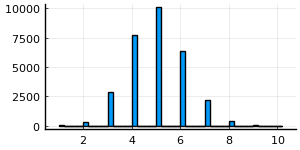

In [6]:
histogram( vcat( getproperty.(tumorinfo.samples, :n)...), size=(300,150), lab="")

In [7]:
print( unique( tumorinfo.Nthresh ))
N = median( unique( tumorinfo.Nthresh ) )

[4455.091495714148, 4455.091495714145]

4455.091495714147

In [59]:
@showprogress for row in eachrow(tumorinfo)
    counts = countmap( vcat( row.samples.mutations...) )
    muts = row.mutations
    muts.samplecount = zeros(Int, nrow(muts))
    muts.samplecount[collect( keys(counts) )] .= values(counts)
end

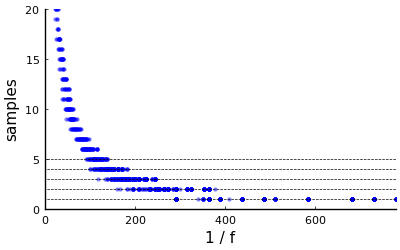

In [177]:
let d = 0.2
    subset = filter(r->r.d == d, tumorinfo)
    
    f = vcat( getproperty.( subset.mutations, :samples_freq)...)
    count = vcat( getproperty.( subset.mutations, :samplecount)...)
    scatter( 1 ./ f[.!iszero.(f)], count[.!iszero.(f)],
        ylim= (0, 20), xlim = (0, :auto), grid=:off, legend=:none, size=(400,250),
        xlab="1 / f", ylab="samples", ms = 3, alpha = 0.5, c=:blue, markerstrokewidth=0
    )
    for n=1:5
       hline!([n], style=:dash, lw = 0.5, c=:black) 
    end
    hline!([samplingparams.n], c=:black)
end

> use known N

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


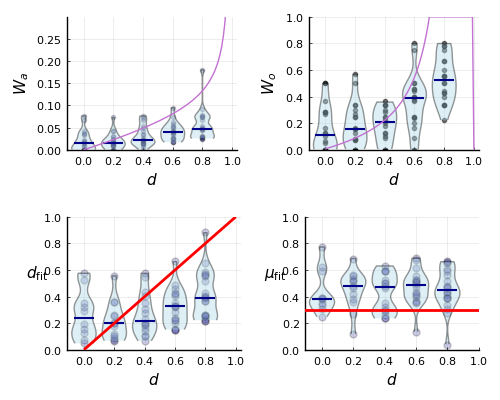

In [187]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


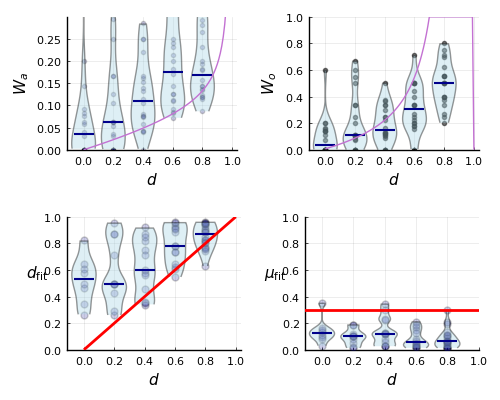

In [132]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


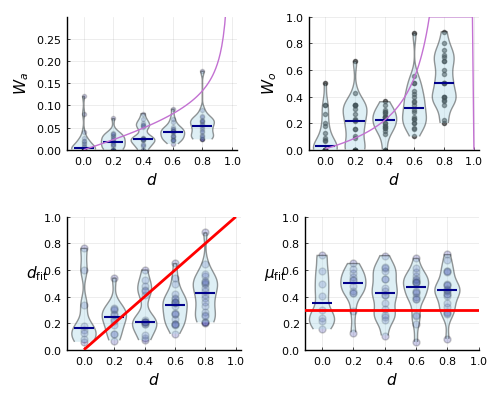

In [118]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


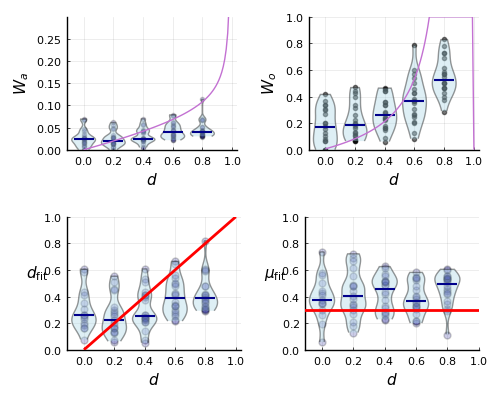

In [181]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


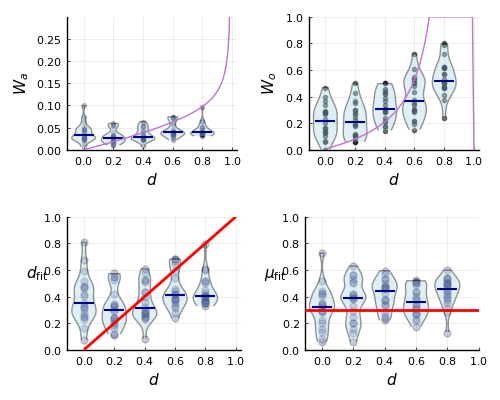

In [182]:
f_min = 1/300
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = true, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=1/f_min,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = 1/f_min)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

> use N estimate & f_min cutoff

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


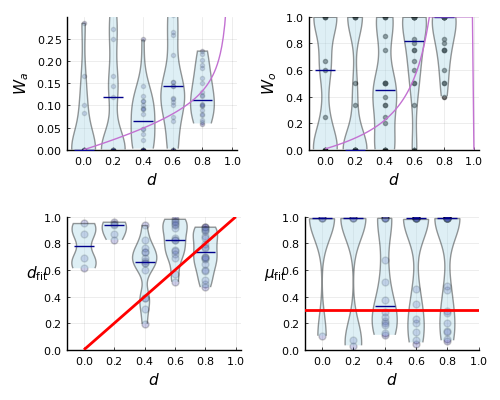

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [36]:
f_min = 1/20
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


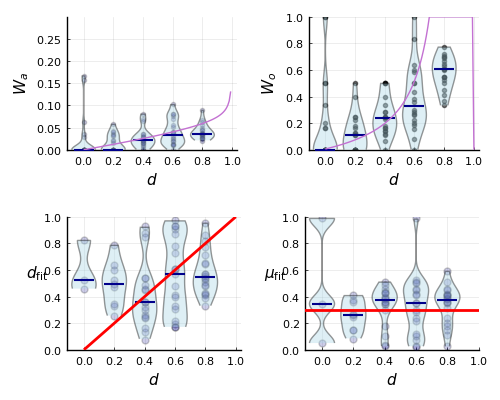

In [188]:
f_min = 1/50
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


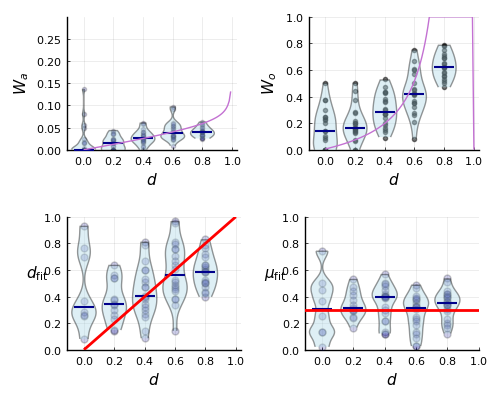

In [185]:
f_min = 1/100
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


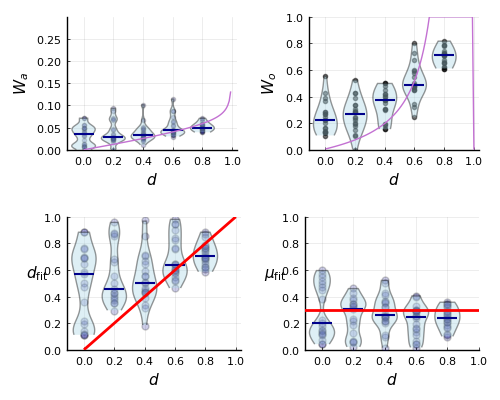

In [189]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


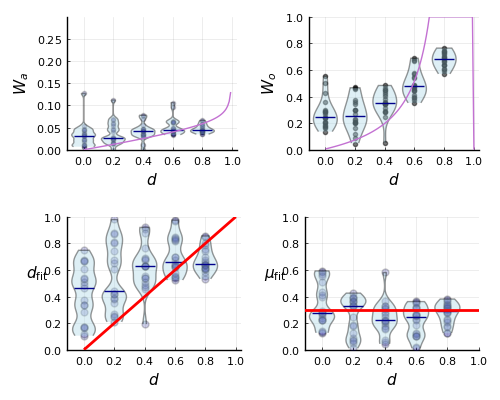

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [10]:
f_min = 1/200
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))

In [12]:
name = "turnover_n280_3d_W"
savefig("Turnover\\turnover_plots\\inference\\"*name*".pdf")
savefig("Turnover\\turnover_plots\\inference\\"*name*".png")

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


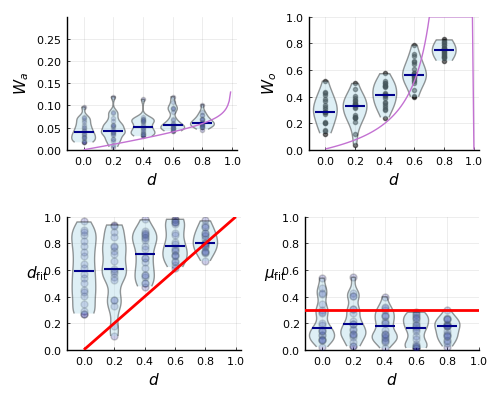

In [190]:
f_min = 1/300
ds, Wa, Wo = get_turnover(tumorinfo; useknown_N = false, f_min=f_min,
    tumor_sample_col = :samples, tumor_sample_func = df -> df,
    mut_freqs_func = TumorGrowth.sampletumor_mfreqs,)

mask = .!(isnan.(Wo))
p1 = plot_turnover_violin(ds[mask], Wa[mask], Wo[mask]; 
    N=N,
    mu=mu, size=(500,200),
    usecorrection=true)

ds, dfits, mufits = infer_params( tumorinfo; Wa, Wo, 
    usecorrection=true, estimate_N = false, N = N)
mask = .!ismissing.(mufits)
p2 = plot_infresult_violin(ds[mask], dfits[mask], mufits[mask]; mu=mu, size=(500,200))

plot(p1,p2, layout = (2,1), size=(500,400))